In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from model_settings import ms
from plotters import PlotCols

pd.set_option('display.max_columns',None)

def HistCols(df,columns=None,sharex=True):
    if columns == None:
        columns = df.columns.tolist()
        sharex = False

    fig,axs=plt.subplots(len(columns),sharex=sharex,figsize=(10,20))
    for i,col in enumerate(columns):
        axs[i].hist(df[col],label=col.replace('_',' '),color='purple',bins=int(np.sqrt(df.shape[0])))
        axs[i].legend()

def test_model(df,pricename):
    df = df.copy()
    df['target_price'] = df[pricename]
    df['observed_price'] = df['relative_observed']*df['strike_price']
    df['pricing_error'] = df['observed_price']-df[pricename]
    df['relative_error'] = df['pricing_error']/df[pricename]
    df['squared_error'] = df['pricing_error']**2
    df['absolute_error'] = np.abs(df['pricing_error'])
    df['absolute_relative'] = np.abs(df['relative_error'])
    desc = df.describe()
    MAE = desc.loc['mean','absolute_error']
    RMSE = np.sqrt(desc.loc['mean','squared_error'])
    MARE = desc.loc['mean','absolute_relative']
    print(f"MAE:\n   {round(MAE,4)}\nRMSE:\n   {round(RMSE,4)}\nMARE:\n   {round(100*MARE,4)}%")
    return df.iloc[:,-7:]

In [2]:
ms.find_root(Path())
models_dir = Path(os.path.join(ms.root,ms.trained_models)).parent
models = pd.Series([f for f in os.listdir(models_dir) if f.endswith('.pkl')])
print(models)

0    2024-11-09 124248013907 retrained_relative_asi...
1    2024-11-09 223743847698 retrained_relative_bar...
dtype: object


In [3]:
model = joblib.load(os.path.join(models_dir,models[1]))
model.keys()

dict_keys(['errors', 'models'])

In [4]:
errors = model['errors']
models = model['models']

['cpu', 'insample_MAE', 'insample_RMSE', 'outofsample_MAE', 'outofsample_RMSE']


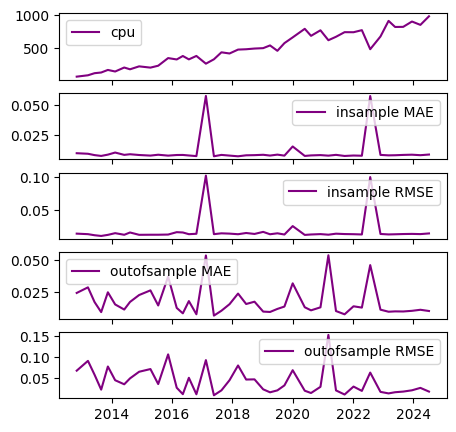

In [5]:
PlotCols(errors,figsize=(5,5))

In [6]:
dates = pd.Series([d for d in models.keys()])
dates.describe()[['min','max']]

min    2012-11-06 00:00:00
max    2024-07-08 00:00:00
dtype: object

In [7]:
model = models[dates.iloc[-1]]
data = model['test_data']
pricename = [n for n in data.columns if n.find('barrier_price')!=-1 or n.find('asian_price')!=-1][0]

In [8]:
df = test_model(data,pricename)
df.columns

MAE:
   1.4313
RMSE:
   3.097
MARE:
   0.7965%


Index(['target_price', 'observed_price', 'pricing_error', 'relative_error',
       'squared_error', 'absolute_error', 'absolute_relative'],
      dtype='object')

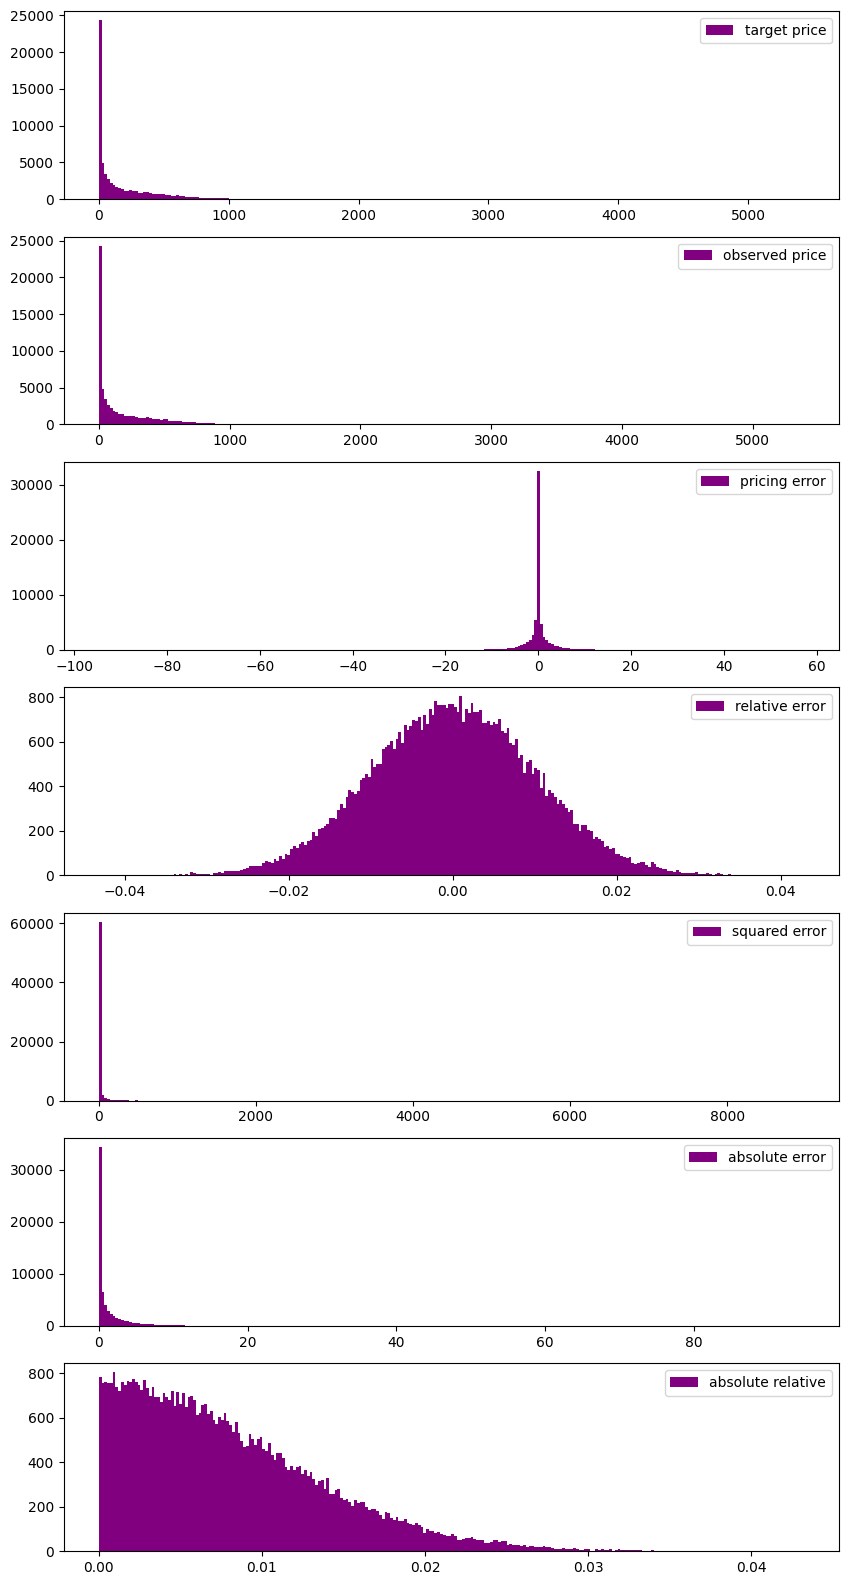

In [9]:
HistCols(df,sharex=False)

In [10]:
estimation = df['observed_price']
target = df['target_price']
relative = df['relative_error']

In [11]:
for k in model.keys():
    print(k)

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [12]:
trained = model['model']
trained

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['days_to_maturity',
                                                                                        'dividend_rate',
                                                                                        'risk_free_rate',
                                                                                        'theta',
                                                                                        'kappa',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'relative_spot',
                                                                                        'relative_barrier',
                                                                                        'relative_rebate']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['w',
                                                                                        'barrier_type_name'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

In [15]:
from itertools import product
import quantlib_pricers as qlp